In [1]:
import copy

from tqdm import tqdm
from PIL import Image

import cv2
import numpy as np
from skimage import filters
from skimage import feature
from scipy.ndimage import gaussian_laplace

from src.data import AUGMENTATIONS_QSD1_W4_LIST, FRAMES_QSD1_W4_LIST, GT_QSD1_W4_LIST
from src.paths import BBDD_PATH, QSD1_W4_PATH, QSD1_NON_AUGMENTED_W4_PATH, WEEK_4_RESULTS_PATH
from src.utils import show_images, show_image_with_mean_values

In [2]:
BBDD_PATH_LIST = sorted(BBDD_PATH.glob("*.jpg"))
QSD1_W4_PATH_LIST = sorted(QSD1_W4_PATH.glob("*.jpg"))
QSD1_NON_AUGMENTED_W4_PATH_LIST = sorted(QSD1_NON_AUGMENTED_W4_PATH.glob("*.jpg"))

In [3]:
database_image_PIL_list = [Image.open(db_img_path) for db_img_path in BBDD_PATH_LIST]  # Load once
for idx, db_img in enumerate(database_image_PIL_list):
    assert db_img.filename.endswith(f"{idx}.jpg")

In [4]:
query_d1_image_PIL_list = [Image.open(query_img_path) for query_img_path in QSD1_W4_PATH_LIST]  # Load once
for idx, query_img in enumerate(query_d1_image_PIL_list):
    assert query_img.filename.endswith(f"{idx}.jpg")

In [5]:
non_augmented_d1_image_PIL_list = [Image.open(query_img_path) for query_img_path in QSD1_NON_AUGMENTED_W4_PATH_LIST]  # Load once
for idx, query_img in enumerate(non_augmented_d1_image_PIL_list):
    assert query_img.filename.endswith(f"{idx}.jpg")

In [6]:
for file, augmentation, frames, gt in zip(QSD1_W4_PATH_LIST, AUGMENTATIONS_QSD1_W4_LIST, FRAMES_QSD1_W4_LIST, GT_QSD1_W4_LIST):
    print(f"File={file.stem}, Aug={augmentation}, Frames={frames}, GT={gt}")

File=00000, Aug=None, Frames=[[np.float64(179.49631381503272), [[64, 41], [2048, 25], [2016, 3653], [196, 3637]]]], GT=[-1]
File=00001, Aug=None-MultiplyHue, Frames=[[np.float64(179.52154949700142), [[19, 38], [509, 37], [496, 665], [17, 661]]]], GT=[150]
File=00002, Aug=None-MultiplyHue, Frames=[[np.float64(0.9495668564358084), [[34, 50], [396, 32], [408, 470], [46, 476]]], [np.float64(0.3015539498682642), [[466, 34], [844, 20], [850, 484], [470, 486]]]], GT=[48, 251]
File=00003, Aug=UnnamedImpulseNoise, Frames=[[np.float64(180.0), [[24, 27], [458, 26], [462, 355], [45, 355]]]], GT=[32]
File=00004, Aug=None-MultiplyHue, Frames=[[np.float64(0.4841781604809512), [[53, 78], [1489, 62], [1497, 2326], [77, 2338]]]], GT=[161]
File=00005, Aug=None, Frames=[[np.float64(179.85346379900508), [[50, 43], [1642, 27], [1646, 2051], [82, 2047]]]], GT=[81]
File=00006, Aug=None, Frames=[[np.float64(1.5481576989779455), [[176, 46], [470, 34], [478, 326], [182, 334]]], [np.float64(1.3510650827196287), [

## EDGE DETECTION

In [ ]:
def get_edges_gabor(img_array: np.ndarray, ksize = 31, sigma = 4.0, lambd = 10.0, gamma = 0.5, phi = 0, thetas = [0, np.pi / 2]) -> np.ndarray:
    # Initialize a list to store filtered images
    filtered_images = []

    # Apply Gabor filters to each channel for each theta
    for c_idx in range(img_array.shape[-1]):
        for theta in thetas:
            gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, phi, ktype=cv2.CV_32F)
            filtered = 255 - cv2.filter2D(img_array[:, :, c_idx], cv2.CV_8UC3, gabor_kernel)
            filtered_images.append(filtered)

    # Combine the filtered images by taking the maximum response
    edges = np.maximum.reduce(filtered_images)

    return edges

def get_edges_canny(img_array: np.ndarray, sigma = 1.0, low_threshold = None, high_threshold = None, use_quantiles = False) -> np.ndarray:
    # Apply Canny edge detection to each channel
    edges_r = feature.canny(img_array[:, :, 0], sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold, use_quantiles=use_quantiles)
    edges_g = feature.canny(img_array[:, :, 1], sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold, use_quantiles=use_quantiles)
    edges_b = feature.canny(img_array[:, :, 2], sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold, use_quantiles=use_quantiles)

    # Combine edges (logical OR)
    edges = np.logical_or(np.logical_or(edges_r, edges_g), edges_b)

    # Convert boolean to int (optional)
    edges = edges.astype(np.uint8) * 255

    return edges

def get_edges_laplacian_of_gaussian(img_array: np.ndarray, sigma = 2.0) -> np.ndarray:
    # Apply Laplacian of Gaussian filter
    edges_r = gaussian_laplace(img_array[:, :, 0], sigma=sigma)
    edges_g = gaussian_laplace(img_array[:, :, 1], sigma=sigma)
    edges_b = gaussian_laplace(img_array[:, :, 2], sigma=sigma)

    # Combine edges and normalize
    edges = np.sqrt(edges_r ** 2 + edges_g ** 2 + edges_b ** 2)
    edges = (edges / edges.max() * 255).astype(np.uint8)

    return edges

In [ ]:
# Load the image
for name, image in zip(QSD1_W4_PATH_LIST, non_augmented_d1_image_PIL_list):

    # Convert the image to grayscale
    img_array  = np.array(image)

    # Define Gabor filter parameters
    ksize = 31  # size of the filter (larger values result in more intense smoothing)
    sigma = 4.0  # standard deviation of the Gaussian function
    lambd = 10.0  # wavelength of the sinusoidal factor
    gamma = 0.5  # spatial aspect ratio
    phi = 0  # phase offset

    # List of theta values (angles in radians)
    thetas = [0, np.pi / 2]  # You can adjust this list as needed

    # Initialize a list to store filtered images
    filtered_images = []

    # Apply Gabor filters to each channel for each theta
    for c_idx in range(img_array.shape[-1]):
        for theta in thetas:
            gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, phi, ktype=cv2.CV_32F)
            filtered = 255 - cv2.filter2D(img_array[:, :, c_idx], cv2.CV_8UC3, gabor_kernel)
            filtered_images.append(filtered)

    # Combine the filtered images by taking the maximum response
    edges = np.maximum.reduce(filtered_images)

    show_images([image, *filtered_images, edges], output_file=WEEK_4_RESULTS_PATH / "edge_detection" / "gabor" / "show_images" / f"{name.stem}.png")
    show_image_with_mean_values(edges, output_file=WEEK_4_RESULTS_PATH / "edge_detection" / "gabor" / "show_image_with_mean_values" / f"{name.stem}.png")

In [ ]:
# Load the image
for name, image in zip(QSD1_W4_PATH_LIST, non_augmented_d1_image_PIL_list):
    # Convert the image to grayscale
    img_array  = np.array(image)

    # Apply Canny edge detection to each channel
    sigma = 2.0
    low_threshold = None
    high_threshold = None
    edges_r = feature.canny(img_array[:, :, 0], sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)
    edges_g = feature.canny(img_array[:, :, 1], sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)
    edges_b = feature.canny(img_array[:, :, 2], sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)

    # Combine edges (logical OR)
    edges = np.logical_or(np.logical_or(edges_r, edges_g), edges_b)

    # Convert boolean to int (optional)
    edges = edges.astype(np.uint8) * 255

    show_images([image, edges_r, edges_g, edges_b, edges], output_file=WEEK_4_RESULTS_PATH / "edge_detection" / "canny" / "show_images" / f"{name.stem}.png")
    show_image_with_mean_values(edges, output_file=WEEK_4_RESULTS_PATH / "edge_detection" / "canny" / "show_image_with_mean_values" / f"{name.stem}.png")

In [ ]:
# Load the image
for name, image in zip(QSD1_W4_PATH_LIST, non_augmented_d1_image_PIL_list):

    # Convert the image to grayscale
    img_array  = np.array(image)

    # Apply Sobel filter on each channel
    edges_r = filters.sobel(img_array[:, :, 0])
    edges_g = filters.sobel(img_array[:, :, 1])
    edges_b = filters.sobel(img_array[:, :, 2])

    # Combine edges
    edges = np.maximum(np.maximum(edges_r, edges_g), edges_b)

    # Convert to uint8
    edges = (edges * 255).astype(np.uint8)

    show_images([image, edges_r, edges_g, edges_b, edges], output_file=WEEK_4_RESULTS_PATH / "edge_detection" / "sobel" / "show_images" / f"{name.stem}.png")
    show_image_with_mean_values(edges, output_file=WEEK_4_RESULTS_PATH / "edge_detection" / "sobel" / "show_image_with_mean_values" / f"{name.stem}.png")

In [ ]:
# Set a sigma
sigma_value = 2.0

# Load the image
for name, image in zip(QSD1_W4_PATH_LIST, non_augmented_d1_image_PIL_list):

    # Convert the image to grayscale
    img_array  = np.array(image)

    # Apply Laplacian of Gaussian filter
    edges_r = gaussian_laplace(img_array[:, :, 0], sigma=sigma_value)
    edges_g = gaussian_laplace(img_array[:, :, 1], sigma=sigma_value)
    edges_b = gaussian_laplace(img_array[:, :, 2], sigma=sigma_value)

    # Combine edges and normalize
    edges = np.sqrt(edges_r ** 2 + edges_g ** 2 + edges_b ** 2)
    edges = (edges / edges.max() * 255).astype(np.uint8)

    show_images([image, edges_r, edges_g, edges_b, edges], output_file=WEEK_4_RESULTS_PATH / "edge_detection" / "LoG" / "show_images" / f"{name.stem}.png")
    show_image_with_mean_values(edges, output_file=WEEK_4_RESULTS_PATH / "edge_detection" / "LoG" / "show_image_with_mean_values" / f"{name.stem}.png")

In [ ]:
# Load the image
for name, image in zip(QSD1_W4_PATH_LIST, non_augmented_d1_image_PIL_list):

    # Convert the image to grayscale
    img_array  = np.array(image.convert("HSV"))

    # Apply Canny edge detection to each channel
    edges_h = feature.canny(img_array[:, :, 0])
    edges_s = feature.canny(img_array[:, :, 1])
    edges_v = feature.canny(img_array[:, :, 2])

    # Combine edges (logical OR)
    edges = np.logical_or(np.logical_or(edges_h, edges_s), edges_v)

    # Convert boolean to int (optional)
    edges = edges.astype(np.uint8) * 255

    show_images([image, edges_h, edges_s, edges_v, edges], output_file=WEEK_4_RESULTS_PATH / "edge_detection" / "canny_hsv" / "show_images" / f"{name.stem}.png")
    show_image_with_mean_values(edges, output_file=WEEK_4_RESULTS_PATH / "edge_detection" / "canny_hsv" / "show_image_with_mean_values" / f"{name.stem}.png")

## RECTANGLE DETECTION

In [ ]:
def merge_contours(contour1, contour2) -> np.ndarray:
    # Concatenate the two contours
    combined = np.concatenate((contour1, contour2))
    # Get the convex hull of the combined contours
    merged_contour = cv2.convexHull(combined)
    return merged_contour

def calculate_contour_distance(contour1, contour2, horizontal_threshold=0, vertical_threshold=0):
    # Get bounding rectangles for both contours
    x1, y1, w1, h1 = cv2.boundingRect(contour1)
    c_x1 = x1 + w1 / 2
    c_y1 = y1 + h1 / 2

    x2, y2, w2, h2 = cv2.boundingRect(contour2)
    c_x2 = x2 + w2 / 2
    c_y2 = y2 + h2 / 2

    # Calculate horizontal and vertical overlaps
    horizontal_overlap = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    vertical_overlap = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))

    # Check if the horizontal and vertical overlap is above the given thresholds
    horizontal_condition = horizontal_overlap > horizontal_threshold
    vertical_condition = vertical_overlap > vertical_threshold

    # Return distance only if both conditions are met
    if horizontal_condition and vertical_condition:
        return max(abs(c_x1 - c_x2) - (w1 + w2) / 2, abs(c_y1 - c_y2) - (h1 + h2) / 2)
    else:
        return float('inf')  # Return a large distance if the conditions aren't met

def agglomerative_cluster(contours, threshold_distance=40.0, horizontal_threshold=0, vertical_threshold=0):
    """https://cullensun.medium.com/agglomerative-clustering-for-opencv-contours-cd74719b678e"""
    current_contours = copy.copy(contours)
    while len(current_contours) > 1:
        min_distance = None
        min_coordinate = None

        for x in range(len(current_contours) - 1):
            for y in range(x + 1, len(current_contours)):
                distance = calculate_contour_distance(
                    current_contours[x], current_contours[y],
                    horizontal_threshold=horizontal_threshold, vertical_threshold=vertical_threshold
                )
                if min_distance is None:
                    min_distance = distance
                    min_coordinate = (x, y)
                elif distance < min_distance:
                    min_distance = distance
                    min_coordinate = (x, y)

        if min_distance < threshold_distance:
            index1, index2 = min_coordinate
            current_contours[index1] = merge_contours(current_contours[index1], current_contours[index2])
            del current_contours[index2]
        else:
            break

    return current_contours

In [ ]:
IMAGE_SIZE = 2 ** 9
MIN_ASPECT_RATIO = 0.125
MAX_ASPECT_RATIO = 8.0
MIN_DISTANCE_TO_MERGE = 10

SIGMA = 2.0

GET_EDGES_FUNCTION = get_edges_canny

In [ ]:
# Load the image
pbar = tqdm(zip(QSD1_W4_PATH_LIST, non_augmented_d1_image_PIL_list, GT_QSD1_W4_LIST))
for name, image, gt in pbar:
    pbar.set_description(f"Processing {name.stem}")

    # Convert the image to grayscale
    img_array  = np.array(image)
    if IMAGE_SIZE:
        img_array = cv2.resize(img_array, dsize=(IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
    print("shape:", img_array.shape)

    # Enhance image
    lab = cv2.cvtColor(img_array, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # Merge channels and convert back to BGR
    lab = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Get edges
    edges = GET_EDGES_FUNCTION(enhanced_img, sigma=SIGMA)

    # Enhance edges
    enhanced_edges = edges.astype(np.uint8)

    # Find contours from the edge image
    contours, _ = cv2.findContours(enhanced_edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(img_array, (x, y), (x + w, y + h), (0, 0, 255), 1)

    # Filter contours
    filtered_contours = []
    discarded_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        if (h >= img_array.shape[0]/4 or w >= img_array.shape[1]/4) and (MIN_ASPECT_RATIO < aspect_ratio < MAX_ASPECT_RATIO):
            filtered_contours.append(contour)
        else:
            discarded_contours.append(contour)

    print("N contours:", len(filtered_contours))

    for contour in discarded_contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(img_array, (x, y), (x + w, y + h), (255, 165, 0), 3)
    for contour in filtered_contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(img_array, (x, y), (x + w, y + h), (0, 255, 0), 3)

    # Extra postprocessing

    # Agglomerative contour clustering
    final_filtered_contours = agglomerative_cluster(filtered_contours, MIN_DISTANCE_TO_MERGE)

    print("N contours after agglomerative contour clustering:", len(final_filtered_contours))

    for contour in final_filtered_contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(img_array, (x, y), (x + w, y + h), (255, 0, 0), 5)

    show_images([image, enhanced_img, edges, enhanced_edges, img_array], output_file=WEEK_4_RESULTS_PATH / "rectangle_detection" / GET_EDGES_FUNCTION.__name__ / "show_images" / f"{name.stem}.png")
    show_image_with_mean_values(img_array, output_file=WEEK_4_RESULTS_PATH / "rectangle_detection" / GET_EDGES_FUNCTION.__name__ / "show_image_with_mean_values" / f"{name.stem}.png")
    
    if not len(final_filtered_contours) == len(gt):
        print(f"MISSMATCH: pred={len(final_filtered_contours)}, gt={len(gt)}")

# FINAL IMPLEMENTATION

In [ ]:
def get_edges_canny(img_array: np.ndarray, sigma = 2.0, low_threshold = None, high_threshold = None, use_quantiles = False) -> np.ndarray:
    # Apply Canny edge detection to each channel
    edges_r = feature.canny(img_array[:, :, 0], sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold, use_quantiles=use_quantiles)
    edges_g = feature.canny(img_array[:, :, 1], sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold, use_quantiles=use_quantiles)
    edges_b = feature.canny(img_array[:, :, 2], sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold, use_quantiles=use_quantiles)

    # Combine edges (logical OR)
    edges = np.logical_or(np.logical_or(edges_r, edges_g), edges_b)

    # Convert boolean to int (optional)
    edges = edges.astype(np.uint8) * 255

    return edges

def merge_contours(contour1, contour2) -> np.ndarray:
    # Concatenate the two contours
    combined = np.concatenate((contour1, contour2))
    # Get the convex hull of the combined contours
    merged_contour = cv2.convexHull(combined)
    return merged_contour

def calculate_contour_distance(contour1, contour2, horizontal_threshold=0, vertical_threshold=0):
    # Get bounding rectangles for both contours
    x1, y1, w1, h1 = cv2.boundingRect(contour1)
    c_x1 = x1 + w1 / 2
    c_y1 = y1 + h1 / 2

    x2, y2, w2, h2 = cv2.boundingRect(contour2)
    c_x2 = x2 + w2 / 2
    c_y2 = y2 + h2 / 2

    # Calculate horizontal and vertical overlaps
    horizontal_overlap = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    vertical_overlap = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))

    # Check if the horizontal and vertical overlap is above the given thresholds
    horizontal_condition = horizontal_overlap > horizontal_threshold
    vertical_condition = vertical_overlap > vertical_threshold

    # Return distance only if both conditions are met
    if horizontal_condition and vertical_condition:
        return max(abs(c_x1 - c_x2) - (w1 + w2) / 2, abs(c_y1 - c_y2) - (h1 + h2) / 2)
    else:
        return float('inf')  # Return a large distance if the conditions aren't met

def agglomerative_cluster(contours, threshold_distance=40.0, horizontal_threshold=0, vertical_threshold=0):
    """https://cullensun.medium.com/agglomerative-clustering-for-opencv-contours-cd74719b678e"""
    current_contours = copy.copy(contours)
    while len(current_contours) > 1:
        min_distance = None
        min_coordinate = None

        for x in range(len(current_contours) - 1):
            for y in range(x + 1, len(current_contours)):
                distance = calculate_contour_distance(
                    current_contours[x], current_contours[y],
                    horizontal_threshold=horizontal_threshold, vertical_threshold=vertical_threshold
                )
                if min_distance is None:
                    min_distance = distance
                    min_coordinate = (x, y)
                elif distance < min_distance:
                    min_distance = distance
                    min_coordinate = (x, y)

        if min_distance < threshold_distance:
            index1, index2 = min_coordinate
            current_contours[index1] = merge_contours(current_contours[index1], current_contours[index2])
            del current_contours[index2]
        else:
            break

    return current_contours

def enhance_image_clahe(image_array: np.ndarray, clip_limit: float = 2.0, tile_grid_size: tuple = (8, 8)) -> np.ndarray:
    """
    Enhances the input image using CLAHE on the L channel in LAB color space.

    Parameters:
    - img_array: np.ndarray - Input image in BGR color space.
    - clip_limit: float - Threshold for contrast limiting (default is 2.0).
    - tile_grid_size: tuple - Size of the grid for histogram equalization (default is (8, 8)).

    Returns:
    - np.ndarray - Enhanced image in BGR color space.
    """
    # Convert to LAB color space
    lab = cv2.cvtColor(image_array, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    cl = clahe.apply(l)

    # Merge channels and convert back to BGR color space
    enhanced_lab = cv2.merge((cl, a, b))
    enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    return enhanced_img

def crop_image(image: np.ndarray, contour) -> np.ndarray:
    x, y, w, h = cv2.boundingRect(contour)
    return image[y:y + h, x:x + w]

def sort_contours(contours):
    """
    Sorts contours based on their spatial arrangement:
    - Horizontally if side by side
    - Vertically if on top of each other

    Parameters:
    - contours: list of contours (each contour is a numpy array of shape (N, 1, 2))

    Returns:
    - list of sorted contours
    """
    # Calculate bounding boxes for each contour
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]

    # Determine orientation based on bounding box overlaps
    total_y_overlap = 0
    total_x_overlap = 0
    for i in range(len(bounding_boxes) - 1):
        x1, y1, w1, h1 = bounding_boxes[i]
        x2, y2, w2, h2 = bounding_boxes[i + 1]
        
        # Calculate overlap in y-axis and x-axis
        y_overlap = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
        x_overlap = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))

        total_y_overlap += y_overlap
        total_x_overlap += x_overlap

    # Determine the predominant alignment based on total overlap
    is_horizontal = total_y_overlap > total_x_overlap

    # Sort contours based on x-coordinates if horizontal, or y-coordinates if vertical
    print(is_horizontal)
    if is_horizontal:
        sorted_contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])  # Sort by x-coordinate
    else:
        sorted_contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])  # Sort by y-coordinate

    return sorted_contours

def get_paintings_cropped_images(image: Image, image_size: int | None = 2**9, min_aspect_ratio: float = 0.125, max_aspect_ratio: float = 8.0, max_distance_to_merge: int = 10, sigma: float = 2.0, output_size: int | None = 2**9) -> list[Image]:
    # Convert the image to grayscale
    image_array  = np.array(image)
    if image_size:
        image_array = cv2.resize(image_array, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)
    
    # Enhance image
    enhanced_image = enhance_image_clahe(image_array)
    
    # Get edges
    edges = get_edges_canny(enhanced_image, sigma=sigma)
    
    # Find contours from the edge image
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    # Filter contours
    filtered_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        if (h >= image_array.shape[0]/4 or w >= image_array.shape[1]/4) and (min_aspect_ratio < aspect_ratio < max_aspect_ratio):
            filtered_contours.append(contour)
    
    # Agglomerative contour clustering
    merged_contours = agglomerative_cluster(filtered_contours, max_distance_to_merge)
    
    if len(merged_contours) > 1:
        merged_contours = sort_contours(merged_contours)
    
    cropped_images = [crop_image(image_array, contour) for contour in merged_contours]
    
    if output_size:
        cropped_images = [cv2.resize(crop, dsize=(output_size, output_size), interpolation=cv2.INTER_CUBIC) for crop in cropped_images]
    
    return [Image.fromarray(crop) for crop in cropped_images]

In [7]:
from src.background import get_paintings_cropped_images

Processing 00000: : 0it [00:00, ?it/s]

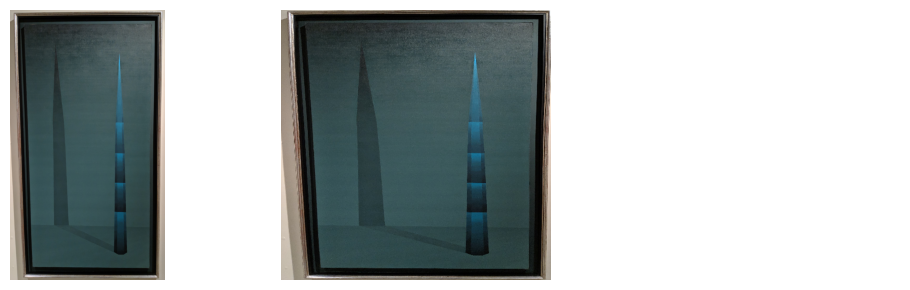

Processing 00001: : 1it [00:00,  1.85it/s]

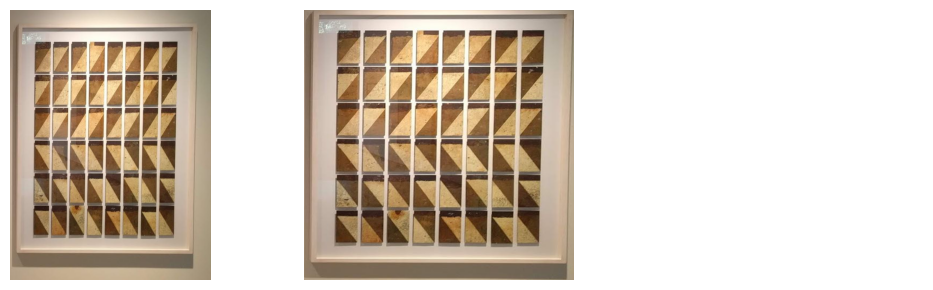

Processing 00002: : 2it [00:00,  3.05it/s]

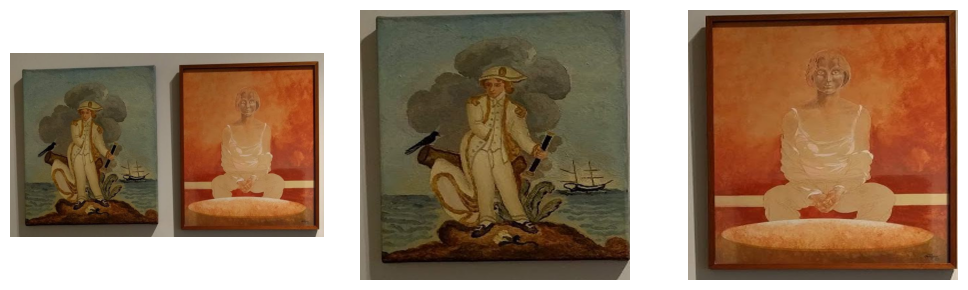

Processing 00003: : 3it [00:00,  3.79it/s]

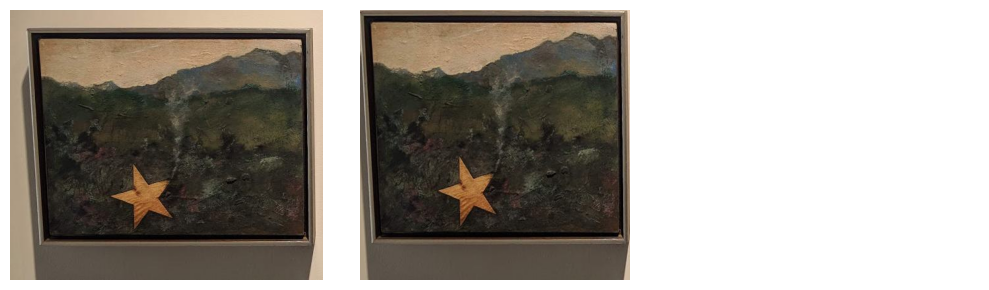

Processing 00004: : 4it [00:01,  4.51it/s]

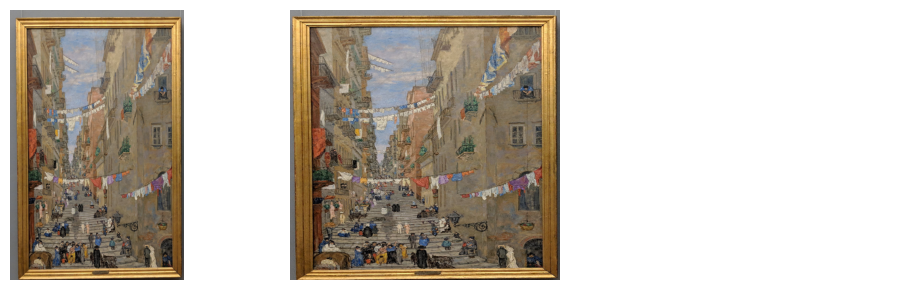

Processing 00005: : 5it [00:01,  4.20it/s]

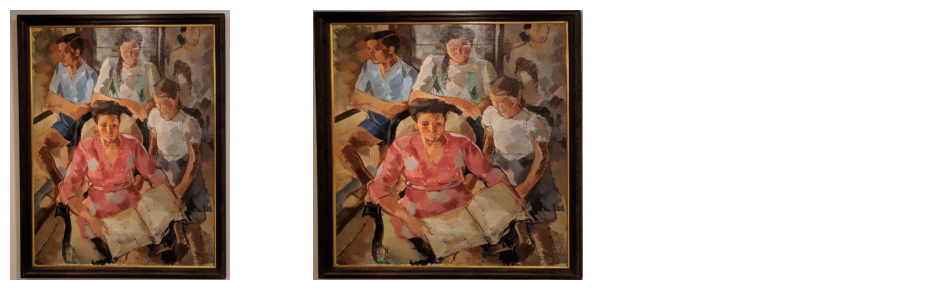

Processing 00006: : 6it [00:01,  4.11it/s]

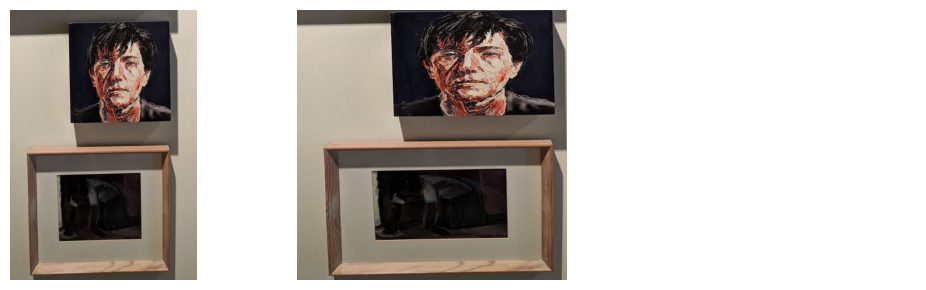

Processing 00007: : 7it [00:01,  4.41it/s]

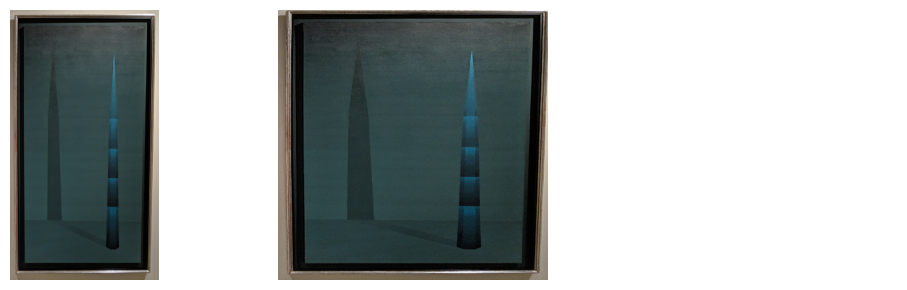

Processing 00008: : 8it [00:02,  4.26it/s]

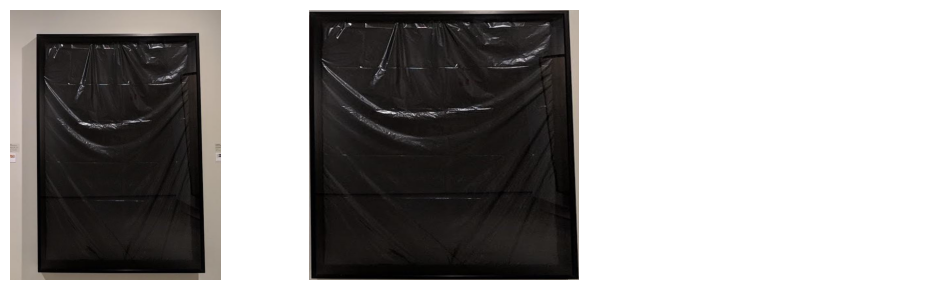

Processing 00009: : 9it [00:02,  4.81it/s]

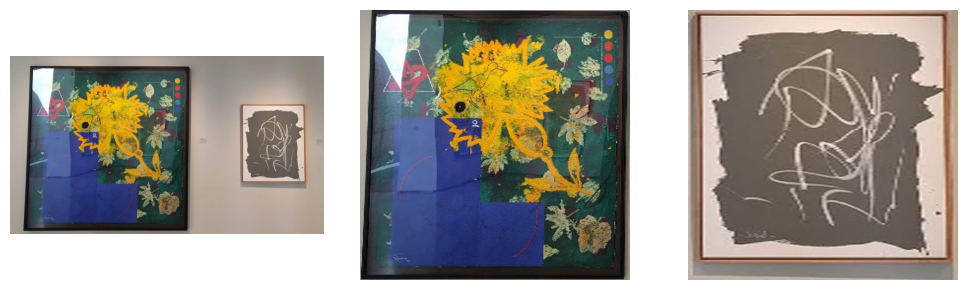

Processing 00010: : 10it [00:02,  4.87it/s]

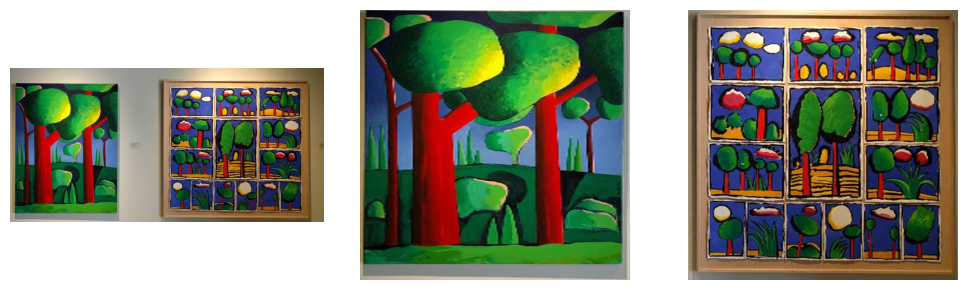

Processing 00011: : 11it [00:02,  4.71it/s]

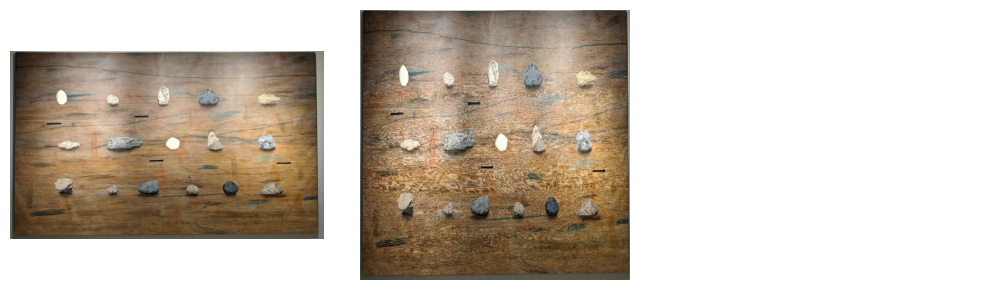

Processing 00012: : 12it [00:02,  3.83it/s]

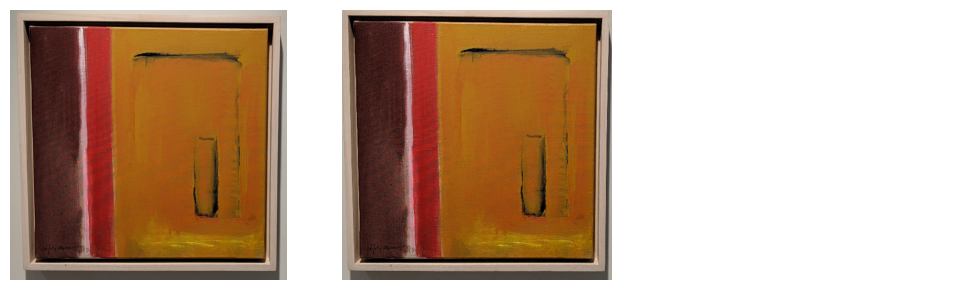

Processing 00013: : 13it [00:03,  3.82it/s]

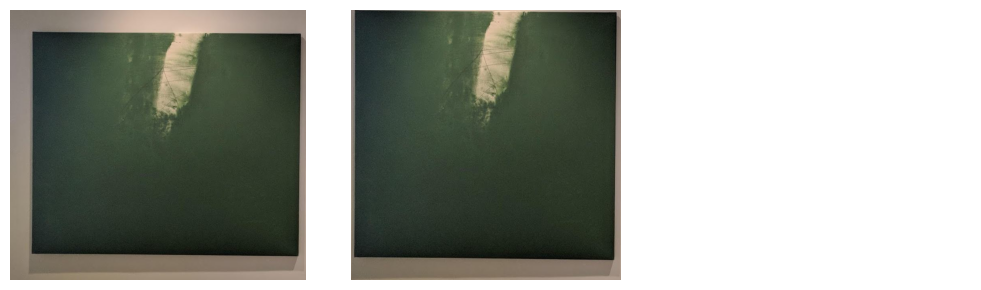

Processing 00014: : 14it [00:03,  4.05it/s]

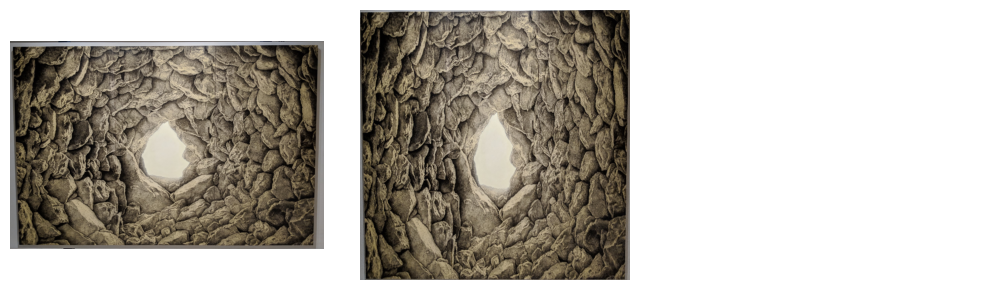

Processing 00015: : 15it [00:03,  2.98it/s]

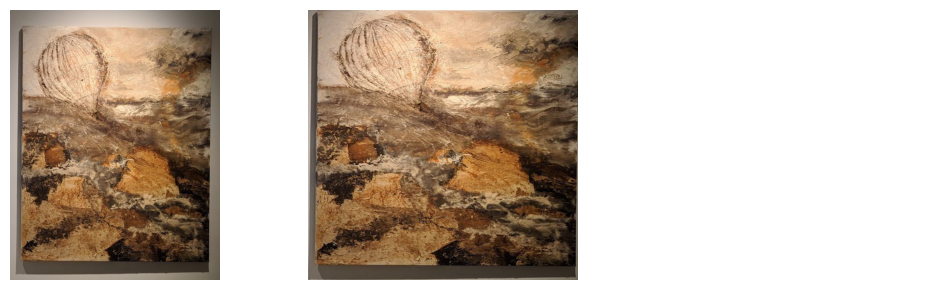

Processing 00016: : 16it [00:04,  3.55it/s]

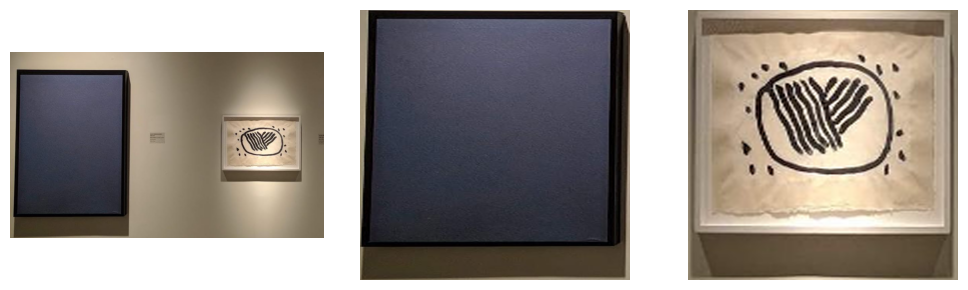

Processing 00017: : 17it [00:04,  3.87it/s]

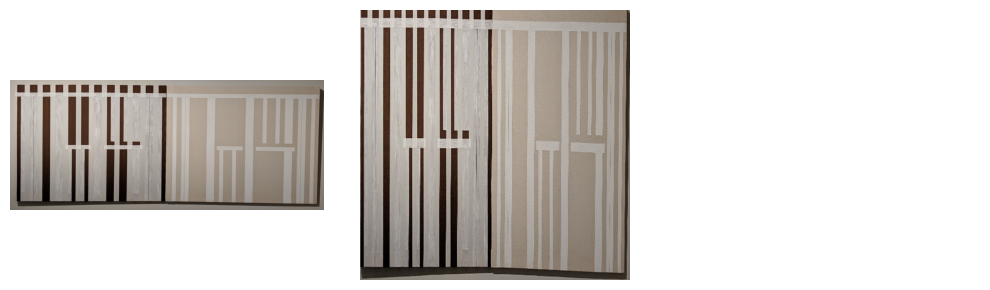

Processing 00018: : 18it [00:04,  3.79it/s]

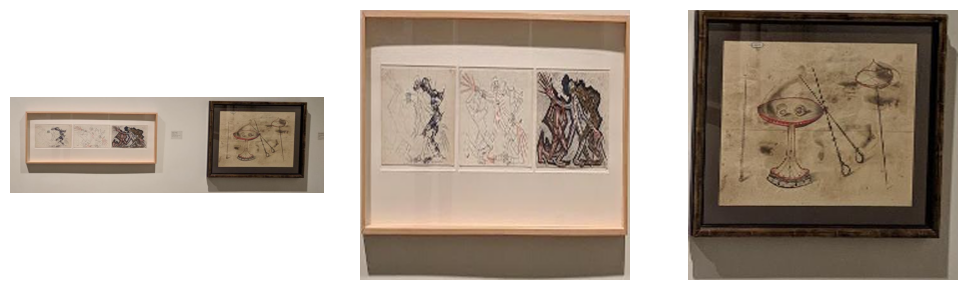

Processing 00019: : 19it [00:04,  4.14it/s]

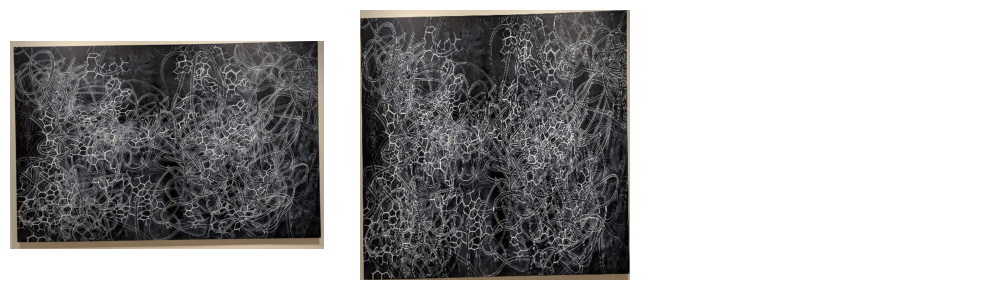

Processing 00020: : 20it [00:05,  3.79it/s]

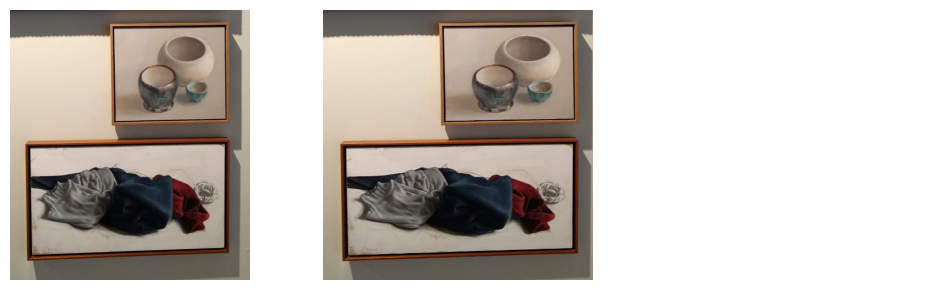

Processing 00021: : 21it [00:05,  4.15it/s]

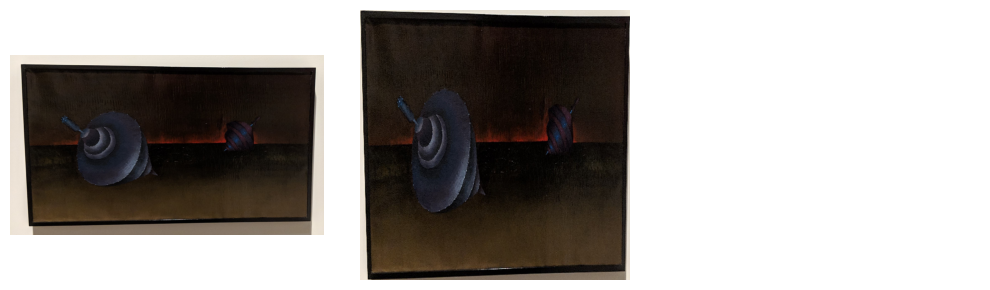

Processing 00022: : 22it [00:05,  4.05it/s]

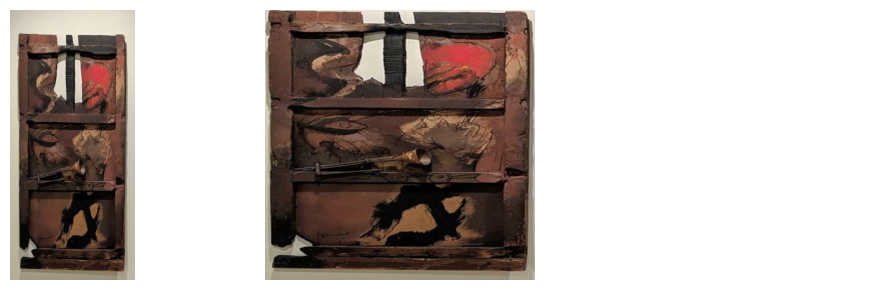

Processing 00023: : 23it [00:05,  4.24it/s]

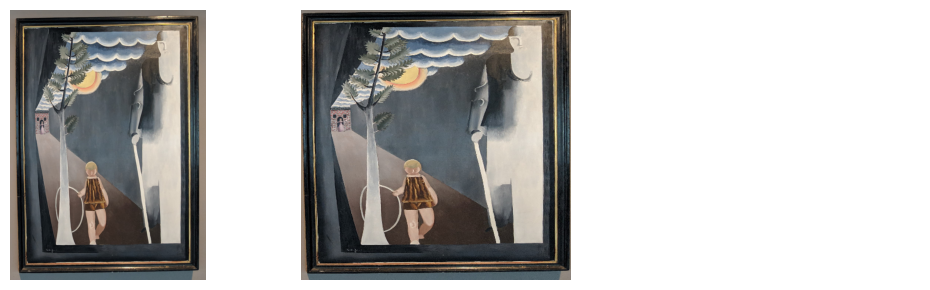

Processing 00024: : 24it [00:06,  4.08it/s]

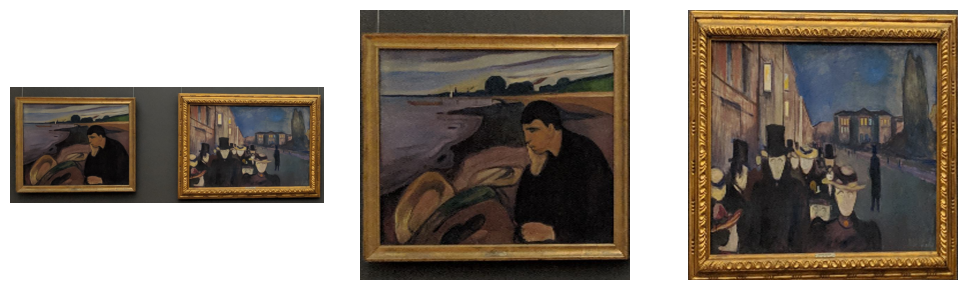

Processing 00025: : 25it [00:06,  4.12it/s]

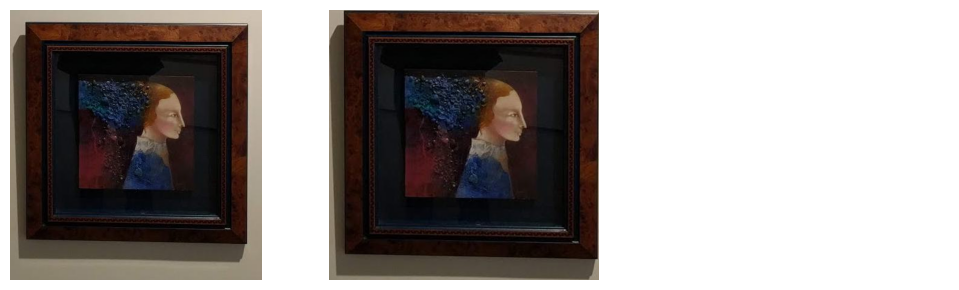

Processing 00026: : 26it [00:06,  4.51it/s]

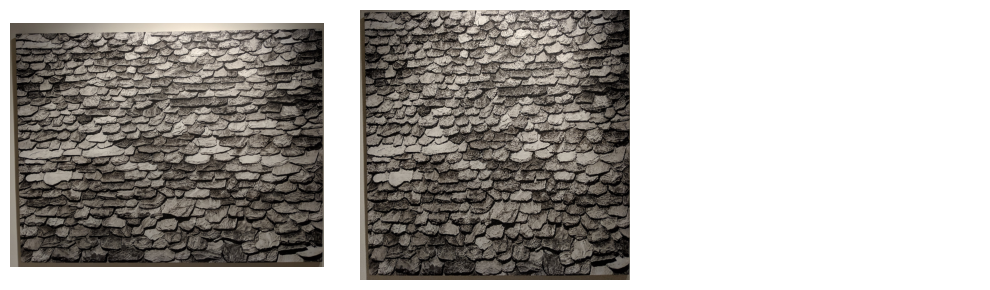

Processing 00027: : 27it [00:06,  3.53it/s]

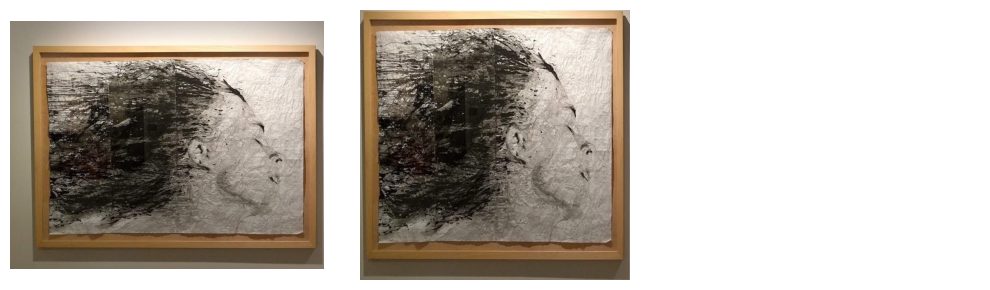

Processing 00028: : 28it [00:07,  4.01it/s]

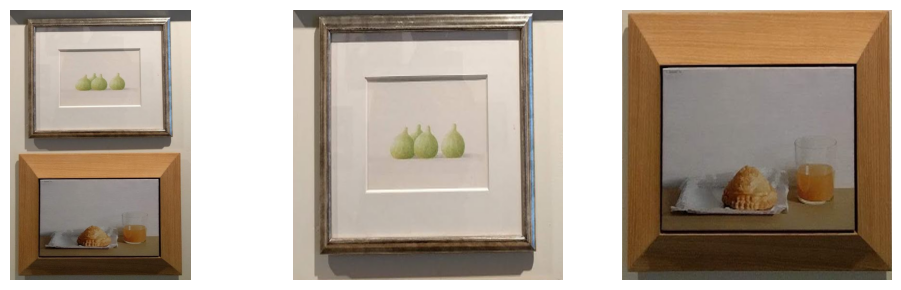

Processing 00029: : 29it [00:07,  4.24it/s]

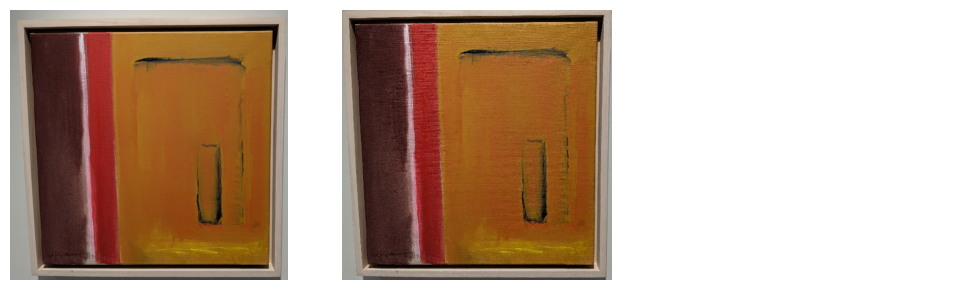

Processing 00029: : 30it [00:07,  3.89it/s]


In [8]:
pbar = tqdm(zip(QSD1_W4_PATH_LIST, non_augmented_d1_image_PIL_list, GT_QSD1_W4_LIST))
for name, image, gt in pbar:
    pbar.set_description(f"Processing {name.stem}")
    show_images([image] + get_paintings_cropped_images(image))